In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define transformations for the dataset
test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


Using device: mps
Files already downloaded and verified
Files already downloaded and verified


In [3]:

# Define the CNN model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Added padding
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # New layer
    self.pool = nn.MaxPool2d(2)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)  # New batch norm
    self.dropout1 = nn.Dropout2d(0.2)  # Reduced dropout
    self.dropout2 = nn.Dropout2d(0.3)

    # Calculate size dynamically
    dummy_input = torch.zeros(1, 3, 32, 32)
    conv_output_size = self._get_conv_output_size(dummy_input)
    
    self.fc1 = nn.Linear(conv_output_size, 256)  # Wider
    self.fc2 = nn.Linear(256, 10)

  def _get_conv_output_size(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.dropout1(x)
    return torch.flatten(x, 1).shape[1]

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and scaler
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
loss_fn = nn.CrossEntropyLoss()

In [4]:
# Training and testing functions
def train(model: CNN, optimizer: optim.Optimizer, loss_fn: nn.CrossEntropyLoss):
  model.train()
  total_loss = 0
  correct = 0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    output: torch.Tensor = model(data)
    loss: torch.Tensor = loss_fn(output, target)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

  accuracy = correct / len(train_loader.dataset)
  return total_loss / len(train_loader), accuracy

def test(model: CNN, loss_fn: nn.CrossEntropyLoss):
  model.eval()
  total_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output: torch.Tensor = model(data)
      loss: torch.Tensor = loss_fn(output, target)

      total_loss += loss.item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  accuracy = correct / len(test_loader.dataset)
  return total_loss / len(test_loader), accuracy


In [5]:
import os
from pathlib import Path
import torch
import glob

def save_model(model: torch.nn.Module, path='models/saved_model.pt'):
  # Create directory if needed
  Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
  
  # If file exists, increment number until we find an unused path
  if os.path.exists(path):
    base, ext = os.path.splitext(path)
    counter = 1
    while os.path.exists(f"{base}_{counter}{ext}"):
      counter += 1
    path = f"{base}_{counter}{ext}"
    
  torch.save(model, path)
  return path

def load_model(path='models/saved_model.pt', number=None):
  if number is not None:
    base, ext = os.path.splitext(path)
    path = f"{base}_{number}{ext}"
  else:
    # Get all matching files
    base, ext = os.path.splitext(path)
    files = glob.glob(f"{base}*{ext}")
    if files:
      path = max(files)  # max will get highest numbered file
  
  if os.path.exists(path):
    model = torch.load(path)
    return model
  else:
    raise FileNotFoundError(f"No model found at {path}")

In [6]:
import os
# Training loop
FORCE_TRAIN = False

if not FORCE_TRAIN and os.path.exists("models/saved_model.pt"):
  model = torch.load("models/saved_model.pt", map_location=device)
else:
  epochs = 50
  for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, optimizer, loss_fn)
    test_loss, test_acc = test(model, loss_fn)
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
  save_model(model)
    

/var/folders/m9/cxt6v3bj4yj_d3cms5m007cm0000gn/T/ipykernel_33518/321212803.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/saved_model.pt", ma

tensor([0], device='mps:0')


/Users/alialh/Development/Alignment/machine-unlearning/.venv/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/var/folders/m9/cxt6v3bj4yj_d3cms5m007cm0000gn/T/ipykernel_33518/1565095014.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45)


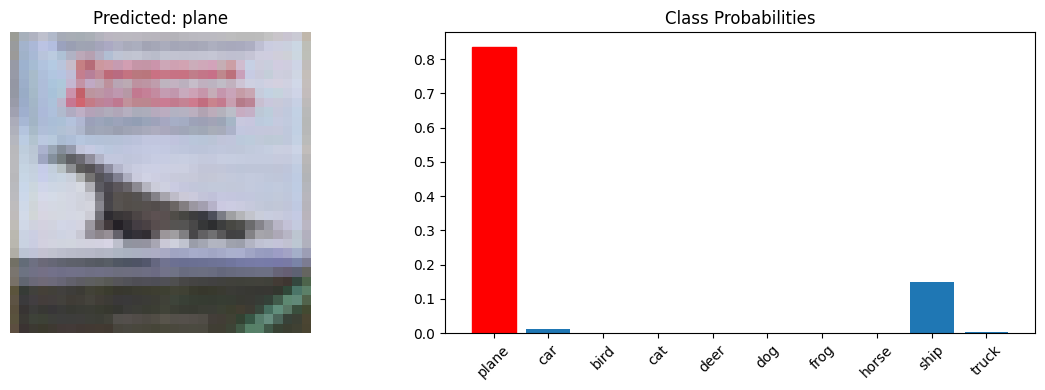

Tensor shape: torch.Size([3, 32, 32])
Value range: [-0.74, 0.84]
Label: 0. plane


In [109]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')

# Method 1: Display a single image from the dataset directly
def show_image(dataset, index):
  # Get image and label
  image, label = dataset[index]

  show_tensor(image, label)
    
def show_tensor(image: torch.Tensor, label=None):
  image = image.cpu()
  # Convert tensor to numpy and transpose from (C,H,W) to (H,W,C)
  image = image.numpy().transpose(1, 2, 0)
  
  # Denormalize the image
  image = image * 0.5 + 0.5  # reverse the normalization you applied
  
  # CIFAR-10 classes
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')
  
  plt.imshow(image)
  plt.title(f'Class: {classes[label] if label else "None Provided"}')
  plt.axis('off')
  plt.show()


# Method 3: If you want to see the raw pixel values
def show_image_details(dataset, index):
  image, label = dataset[index]
  print(f"Tensor shape: {image.shape}")
  print(f"Value range: [{image.min():.2f}, {image.max():.2f}]")
  print(f"Label: {label}. {classes[label]}")
  
def show_augmented_images(dataset, index, num_augmentations=5):
  # Get original image
  image, label = dataset[index]
  
  # Create a figure with num_augmentations+1 subplots (including original)
  fig, axes = plt.subplots(1, num_augmentations+1, figsize=(15, 3))
  
  # Show original
  axes[0].imshow(image.numpy().transpose(1, 2, 0) * 0.5 + 0.5)
  axes[0].set_title('Original')
  axes[0].axis('off')
  
  # Show augmented versions
  for i in range(num_augmentations):
    # Get the same image again (it will be newly augmented)
    aug_image, _ = dataset[index]
    axes[i+1].imshow(aug_image.numpy().transpose(1, 2, 0) * 0.5 + 0.5)
    axes[i+1].set_title(f'Augmented {i+1}')
    axes[i+1].axis('off')
  
  plt.tight_layout()
  plt.show()

def predict_with_plot(input: torch.Tensor, unsqueeze: bool = False):
  if unsqueeze: input = input.unsqueeze(0)
  with torch.no_grad():
    input = input.to(device)
    output: torch.Tensor = model(input)
    probs = torch.exp(output)
    pred = output.argmax(dim=1)
    print(pred)
    pred_class = classes[pred.item()]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image in first subplot
    img = input[0].cpu().numpy().transpose(1, 2, 0)
    img = img * 0.5 + 0.5
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {pred_class}')
    ax1.axis('off')
    
    # Show probabilities in second subplot
    probs_np = probs[0].cpu().numpy()
    bars = ax2.bar(classes, probs_np)
    ax2.set_title('Class Probabilities')
    ax2.set_xticklabels(classes, rotation=45)
    
    # Color the predicted class bar differently
    bars[pred.item()].set_color('red')
    
    plt.tight_layout()
    plt.show()


# Test it
image, label = test_dataset[3]
image_unsqueezed = image.unsqueeze(0)
predict_with_plot(image_unsqueezed)
show_image_details(test_dataset, 3)

In [110]:
from torchvision.utils import save_image

/Users/alialh/Development/Alignment/machine-unlearning/.venv/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


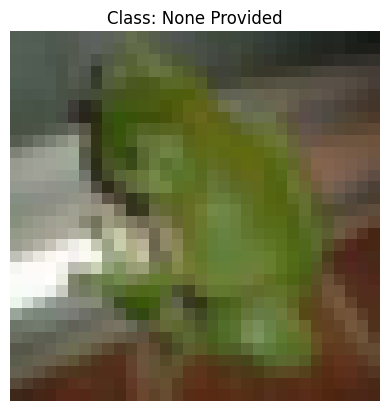

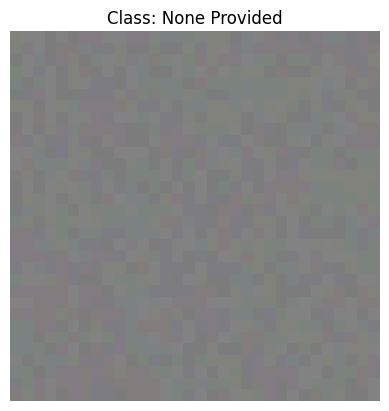

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.044901967..1.01].


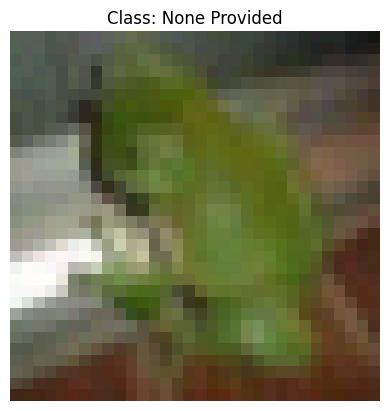

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.044901967..1.01].


tensor([2], device='mps:0')


/var/folders/m9/cxt6v3bj4yj_d3cms5m007cm0000gn/T/ipykernel_33518/1565095014.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45)


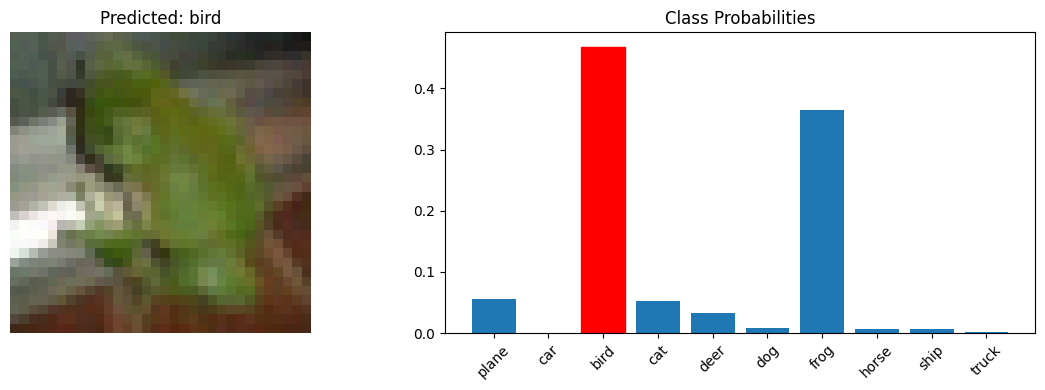

In [158]:
def get_gradient_sign(image: torch.Tensor):
  input: torch.Tensor = image.to(device).unsqueeze(0)
  input.requires_grad = True
  output = model(input)
  loss_fn = nn.CrossEntropyLoss()
  loss: torch.Tensor = loss_fn(output, torch.tensor([label], device=device))

  loss.backward()

  res = torch.sign(input.grad)
  res = res[0].to("cpu")

  return res

image, label = test_dataset[7]

EPSILON = 0.02
gradient = get_gradient_sign(image)

pertubation = EPSILON * gradient
show_tensor(image)
show_tensor(pertubation)

adv_image = image + pertubation

show_tensor(adv_image)

predict_with_plot(adv_image, unsqueeze=True)

In [159]:
from PIL import Image
import imagehash

save_image(image, "image_test.jpg")
save_image(adv_image, "adv_image_test.jpg")

# Load images
image1 = Image.open('image_test.jpg')
image2 = Image.open('adv_image_test.jpg')

# Calculate perceptual hashes
hash1 = imagehash.phash(image1)
hash2 = imagehash.phash(image2)

# Define a threshold value
threshold = 0.5

# Calculate the Hamming distance between the hashes
hamming_distance = hash1 - hash2

# Compare the Hamming distance with the threshold
if hamming_distance <= threshold:
    print("Perceptually similar.")
else:
    print("Not perceptually similar.")

Perceptually similar.


### Unfinished Test. 'Merging' two images to make a poisoned one.

Idea: essentially run a gradient descent typa algo. You have a step size and an epsilon. You keep going in the right direction of the poisoned set, optimizing for something that is perceptually similar but still the wrong label.

tensor([6], device='mps:0')


/Users/alialh/Development/Alignment/machine-unlearning/.venv/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/var/folders/m9/cxt6v3bj4yj_d3cms5m007cm0000gn/T/ipykernel_33518/1565095014.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45)


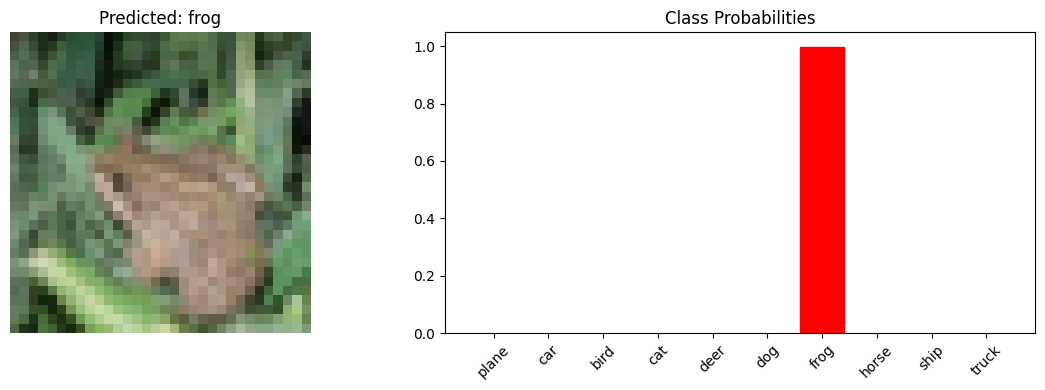

tensor([7], device='mps:0')


/Users/alialh/Development/Alignment/machine-unlearning/.venv/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/var/folders/m9/cxt6v3bj4yj_d3cms5m007cm0000gn/T/ipykernel_33518/1565095014.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45)


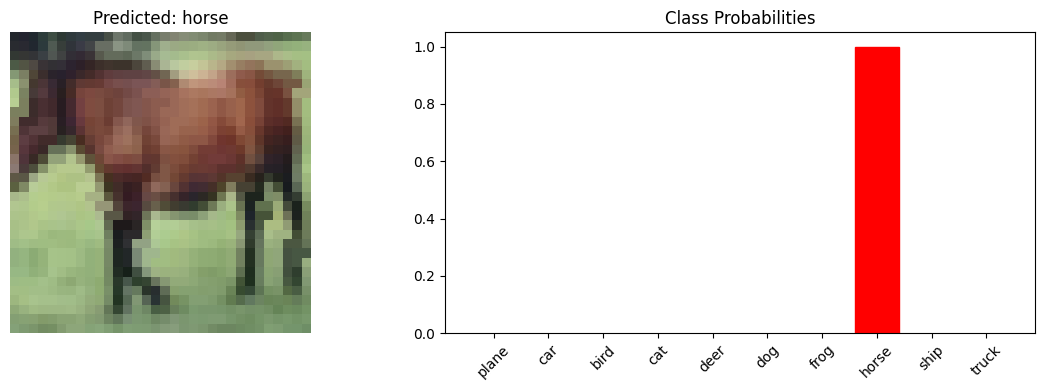

In [103]:
image_1, label = test_dataset[4]
image_2, label = train_dataset[7]

predict_with_plot(image_1, unsqueeze=True)
predict_with_plot(image_2, unsqueeze=True)


In [ ]:
INITIAL_STEP = 0.1
INITIAL_EPSILON = 0.5

# How can we measure whether an image still looks original?

/Users/alialh/Development/Alignment/machine-unlearning/.venv/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


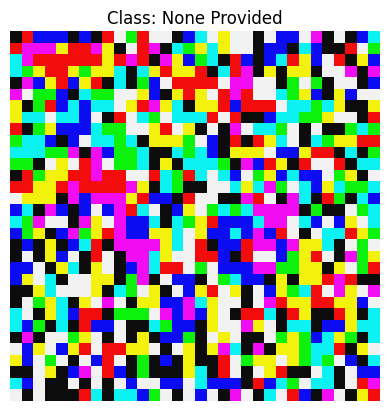

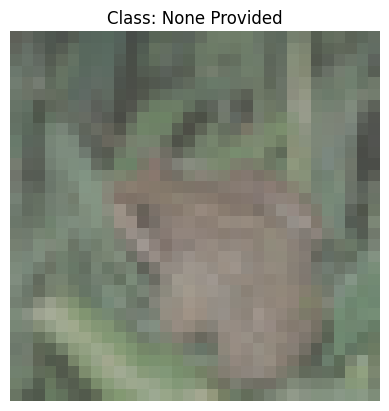

tensor([4], device='mps:0')


/var/folders/m9/cxt6v3bj4yj_d3cms5m007cm0000gn/T/ipykernel_33518/1565095014.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45)


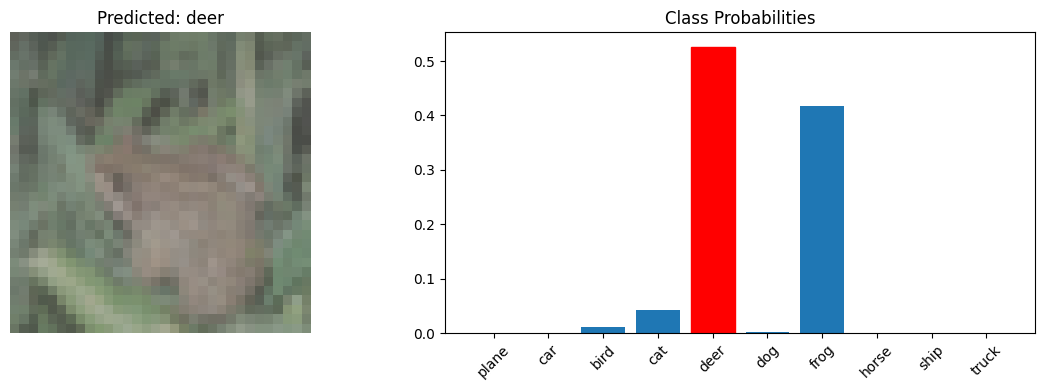

In [107]:
EPSILON = 0.9
gradient = get_gradient_sign(image_2)

pertubation = EPSILON * gradient
show_tensor(pertubation)

adv_image = ((EPSILON*image_1) + ((1-EPSILON)*image_2)) / 2

show_tensor(adv_image)

predict_with_plot(adv_image, unsqueeze=True)